CocaCola sales seem to follow a cycle of four quarters (using quarterly data). We model the sales below.

In the linear model of seasonality:

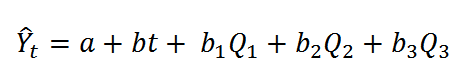

the coefficients of the dummy variables b1, b2 and b3 indicate how much each quarter differs from the reference quarter, quarter4.
The average increase from one quarter to the next is b (the coefficient of t). This is the trend effect.  Quarter 1 averages b1 units higher than the reference quarter, quarter 4, quarter 2 averages b2 units higher than quarter 4, etc. These other coefficients indicate the effect of seasonality.


In what follows we are implementing a multiplicative seasonal model of seasonality:


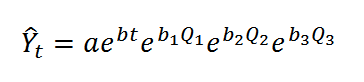

Which after taking logs is:

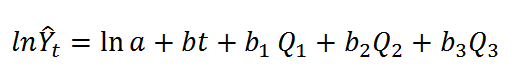

In this multiplicative model the coefficients are percentage changes in the original sales variable Y.  The coefficient of time means that deseasonalized sales increase by b% per quarter. This is the trend effect. The coefficients b1, b2 and b3 mean that the sales in quarters 1, 2 and 3 are respectively b1% above quarter 4, b2% above quarter 4 and b3% above quarter 4. Quarter 4 is the reference quarter.

In [ ]:
import pandas as pd
import numpy as np
from sklearn.model_selection import TimeSeriesSplit
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error
from sklearn.model_selection import cross_val_score
import matplotlib.pyplot as plt
%matplotlib inline

In [ ]:
#The following function is borrowed from :  Dmitriy Sergeyev, Data Scientist @ Zeptolab, lecturer in the Center of Mathematical Finance in MSU
#https://mlcourse.ai/articles/topic9-part1-time-series/

import statsmodels.api as sm
import statsmodels.tsa.api as smt

def tsplot(y, lags=None, figsize=(12, 7), style='bmh'):
    """
        Plot time series, its ACF and PACF, calculate Dickey–Fuller test

        y - timeseries pandas series
        lags - how many lags to include in ACF, PACF calculation
    """
    if not isinstance(y, pd.Series):
        y = pd.Series(y)

    with plt.style.context(style):
        fig = plt.figure(figsize=figsize)
        layout = (2, 2)
        ts_ax = plt.subplot2grid(layout, (0, 0), colspan=2)
        acf_ax = plt.subplot2grid(layout, (1, 0))
        pacf_ax = plt.subplot2grid(layout, (1, 1))

        y.plot(ax=ts_ax)
        p_value = sm.tsa.stattools.adfuller(y)[1]
        ts_ax.set_title('Time Series Analysis Plots\n Agumented Dickey-Fuller: p={0:.5f}'.format(p_value))
        smt.graphics.plot_acf(y, lags=lags, ax=acf_ax)
        smt.graphics.plot_pacf(y, lags=lags, ax=pacf_ax)
        plt.tight_layout()

In [ ]:
def detrendPrice(dft):
    #make sure the input dft has no Nan, otherwise OLS will break
    # fit linear model
    series=dft.Sales
    length = len(series)
    x = np.arange(length)
    y = np.array(series.values)
    x_const = sm.add_constant(x) #need to add intercept constant
    model = sm.OLS(y,x_const)
    results = model.fit()
    predictions = results.predict(x_const)
    resid = y - predictions
    df=pd.DataFrame(resid, columns=['Sales'])
    df.index = dft.index
    return df

In [ ]:
def MAD_mean_ratio(y_true, y_pred):
    return np.mean(np.abs((y_true - y_pred) / np.mean(y_true))) * 100

In [ ]:
#The following 2 functions are borrowed from :  Dmitriy Sergeyev, Data Scientist @ Zeptolab, lecturer in the Center of Mathematical Finance in MSU
#https://mlcourse.ai/articles/topic9-part1-time-series/

def plotModelResults(model, X_train, X_test, y_test, plot_intervals=False, test_data=True):
    """
        Plots modelled vs fact values, prediction intervals

    """
    from sklearn.model_selection import cross_val_score
    from sklearn.model_selection import TimeSeriesSplit
    tscv = TimeSeriesSplit(n_splits=5)

    prediction = model.predict(X_test)

    plt.figure(figsize=(15, 7))
    plt.plot(prediction, "g", label="prediction", linewidth=2.0)
    plt.plot(y_test.values, label="actual", linewidth=2.0)

    if plot_intervals:
        cv = cross_val_score(model, X_train, y_train,
                                    cv=tscv,
                                    scoring="neg_mean_absolute_error")
        mae = cv.mean() * (-1)
        deviation = cv.std()

        scale = 1.96
        lower = prediction - (mae + scale * deviation)
        upper = prediction + (mae + scale * deviation)

        plt.plot(lower, "r--", label="upper bond / lower bond", alpha=0.5)
        plt.plot(upper, "r--", alpha=0.5)

    error = MAD_mean_ratio(prediction, y_test)
    if (test_data==True):
        plt.title("Test data MAD_mean_ratio error {0:.2f}%".format(error))
    else:
        plt.title("Train data MAD_mean_ratio error {0:.2f}%".format(error))
    plt.legend(loc="best")
    plt.tight_layout()
    plt.grid(True);

def plotCoefficients(model,X_train):
    """
        Plots sorted coefficient values of the model
    """

    coefs = pd.DataFrame(model.coef_, X_train.columns)
    coefs.columns = ["coef"]
    coefs["abs"] = coefs.coef.apply(np.abs)
    coefs = coefs.sort_values(by="abs", ascending=False).drop(["abs"], axis=1)

    plt.figure(figsize=(15, 7))
    coefs.coef.plot(kind='bar')
    plt.grid(True, axis='y')
    plt.hlines(y=0, xmin=0, xmax=len(coefs), linestyles='dashed');

In [ ]:
# Read the CSV file, parsing the 'Date' column as datetime
df = pd.read_csv('CocaCola.csv', parse_dates=['Date'], infer_datetime_format=True)

# Convert the 'Date' column to datetime and create a new 'datetime' column
df["datetime"] = pd.to_datetime(df['Date'])

# Set the 'datetime' column as the index of the DataFrame
df.set_index('datetime', inplace=True)

# Drop the original 'Date' column from the DataFrame
df.drop(["Date"], axis=1, inplace=True)

# Display the first few rows of the DataFrame
df.head()

<ipython-input-58-8bb032c64c10>:2: FutureWarning: The argument 'infer_datetime_format' is deprecated and will be removed in a future version. A strict version of it is now the default, see https://pandas.pydata.org/pdeps/0004-consistent-to-datetime-parsing.html. You can safely remove this argument.
  df = pd.read_csv('CocaCola.csv', parse_dates=['Date'], infer_datetime_format=True)


,Sales
datetime,
1986-04-01,1734.83
1986-07-01,2244.96
1986-10-01,2533.80
1987-01-01,2154.96
1987-04-01,1547.82


,Sales,quarter
datetime,,
1986-04-01,7.458665,2
1986-07-01,7.716443,3
1986-10-01,7.837475,4
1987-01-01,7.675527,1
1987-04-01,7.344603,2


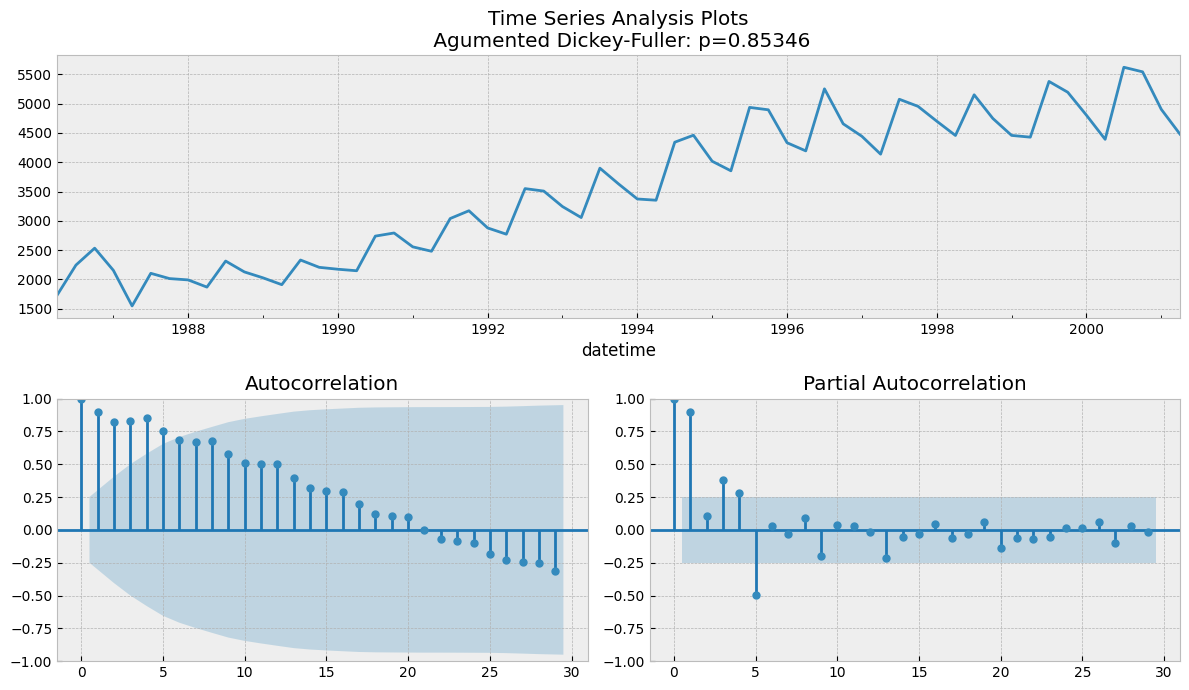

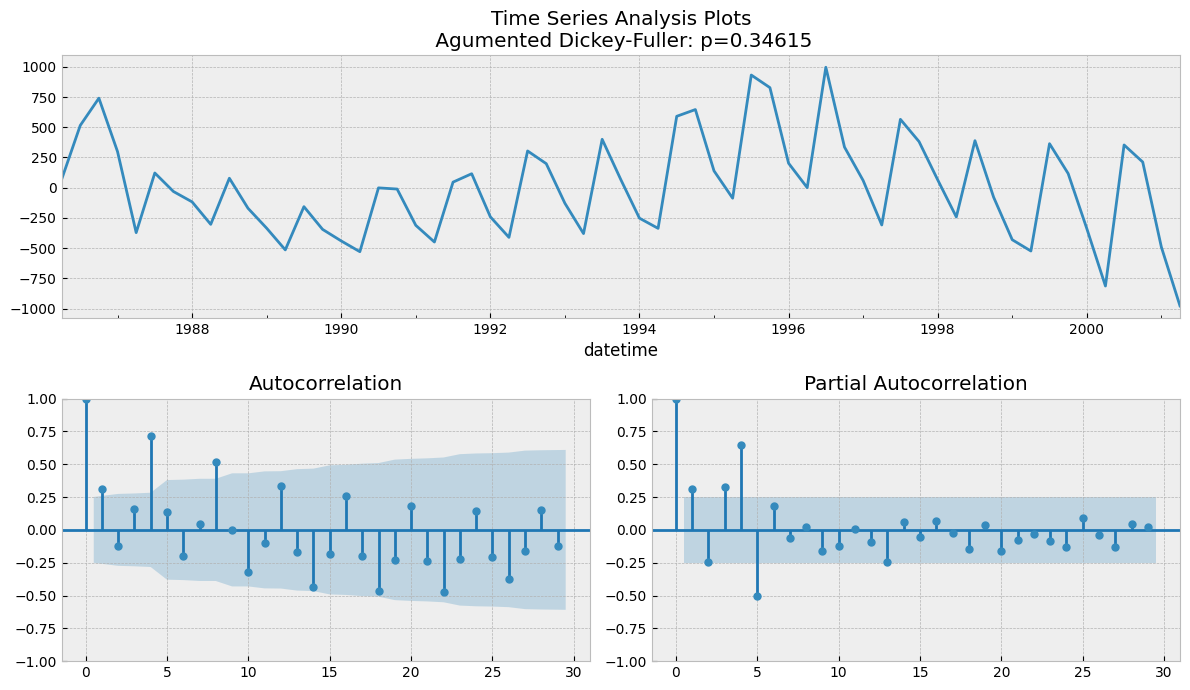

In [ ]:
# Plot original Sales data
tsplot(df["Sales"], lags=29)

# Handle missing values
df.dropna(inplace=True)

# Detrend the data
df_detrended = detrendPrice(df)

# Plot detrended data
tsplot(df_detrended["Sales"], lags=29)

# Apply log transformation for multiplicative seasonal model
df["Sales"] = np.log(df["Sales"])

# Generate quarter column
df["quarter"] = df.index.quarter

# Print first few rows
df.head()

In [ ]:
# Assuming 'df' is already created and contains a 'quarter' column
df_dummies = pd.get_dummies(df["quarter"], prefix="quarter").astype(int)

# Print first 5 rows
df_dummies.head()

,quarter_1,quarter_2,quarter_3,quarter_4
datetime,,,,
1986-04-01,0,1,0,0
1986-07-01,0,0,1,0
1986-10-01,0,0,0,1
1987-01-01,1,0,0,0
1987-04-01,0,1,0,0


In [ ]:
# Join the dummy variables with the original DataFrame
df = df.join(df_dummies)

# Print first few rows
df.head()

,Sales,quarter,quarter_1,quarter_2,quarter_3,quarter_4
datetime,,,,,,
1986-04-01,7.458665,2,0,1,0,0
1986-07-01,7.716443,3,0,0,1,0
1986-10-01,7.837475,4,0,0,0,1
1987-01-01,7.675527,1,1,0,0,0
1987-04-01,7.344603,2,0,1,0,0


In [ ]:
# Drop the "quarter" and "quarter_4" columns
df.drop(["quarter", "quarter_4"], inplace=True, axis=1)

# Print the first few rows
df.head()

,Sales,quarter_1,quarter_2,quarter_3
datetime,,,,
1986-04-01,7.458665,0,1,0
1986-07-01,7.716443,0,0,1
1986-10-01,7.837475,0,0,0
1987-01-01,7.675527,1,0,0
1987-04-01,7.344603,0,1,0


In [ ]:
# Generate a list of sequential numbers from 0 to df.shape[0] - 1
df["time"] = list(range(0, df.shape[0]))

# Print the first few rows
df.head()


,Sales,quarter_1,quarter_2,quarter_3,time
datetime,,,,,
1986-04-01,7.458665,0,1,0,0
1986-07-01,7.716443,0,0,1,1
1986-10-01,7.837475,0,0,0,2
1987-01-01,7.675527,1,0,0,3
1987-04-01,7.344603,0,1,0,4


In [ ]:
# Extract the target variable
y = df["Sales"]

# Drop 'Sales' from features and save the result as X
df.drop(["Sales"], inplace=True, axis=1)
X = df  # Now X contains only independent variables

# Split data into 80% training and 20% testing sets (without shuffling)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=False, random_state=42)

# Instantiate a Linear Regression model
lr = LinearRegression()

# Fit the model to the training set
lr_fitted = lr.fit(X_train, y_train)

# Predict on the training set (interpolation)
predictions_train = lr_fitted.predict(X_train)

# Predict on the testing set (forecasting)
predictions_test = lr_fitted.predict(X_test)

In [ ]:
# Evaluate on training data
train_error = MAD_mean_ratio(y_train, predictions_train)
print(f"Train MAD/MEAN Ratio Error: {train_error}")

# Evaluate on testing data
test_error = MAD_mean_ratio(y_test, predictions_test)
print(f"Test MAD/MEAN Ratio Error: {test_error}")

Train MAD/MEAN Ratio Error: 0.751375633467679
Test MAD/MEAN Ratio Error: 2.5127729607789915


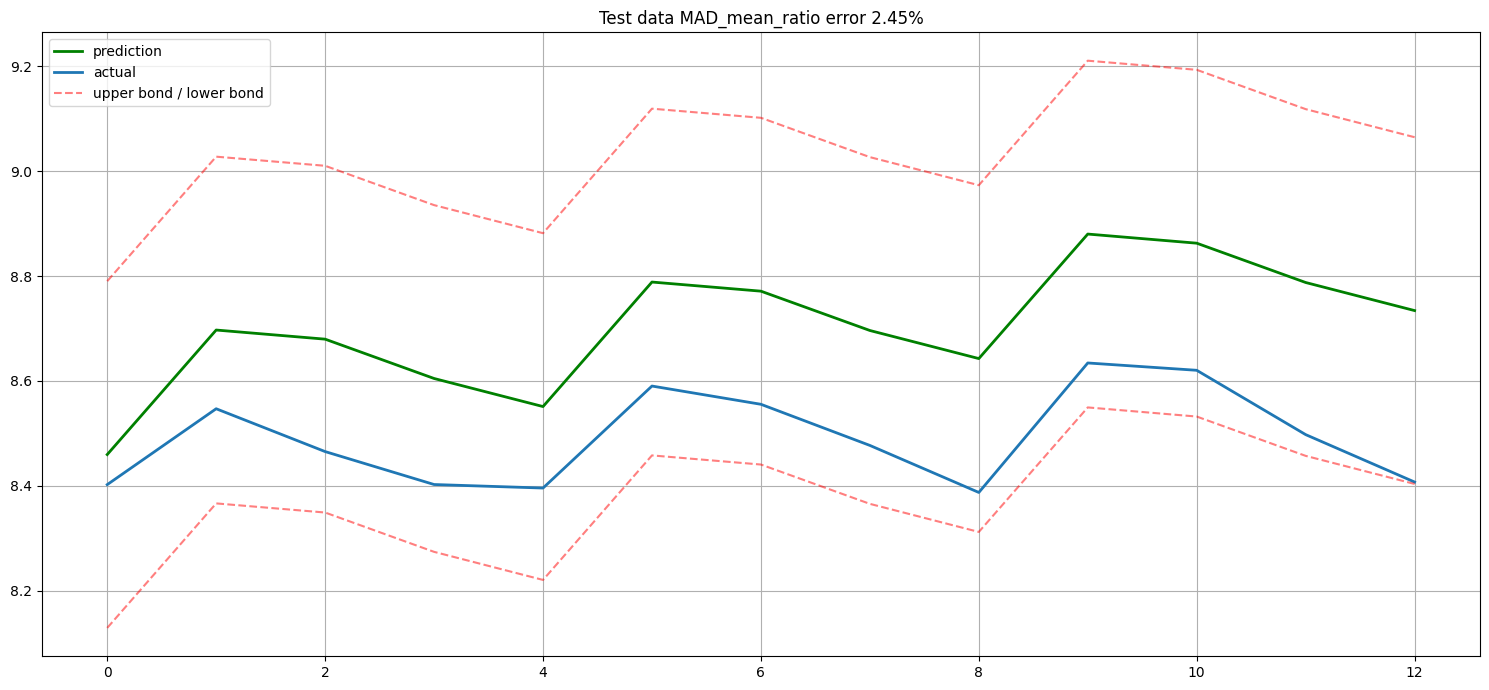

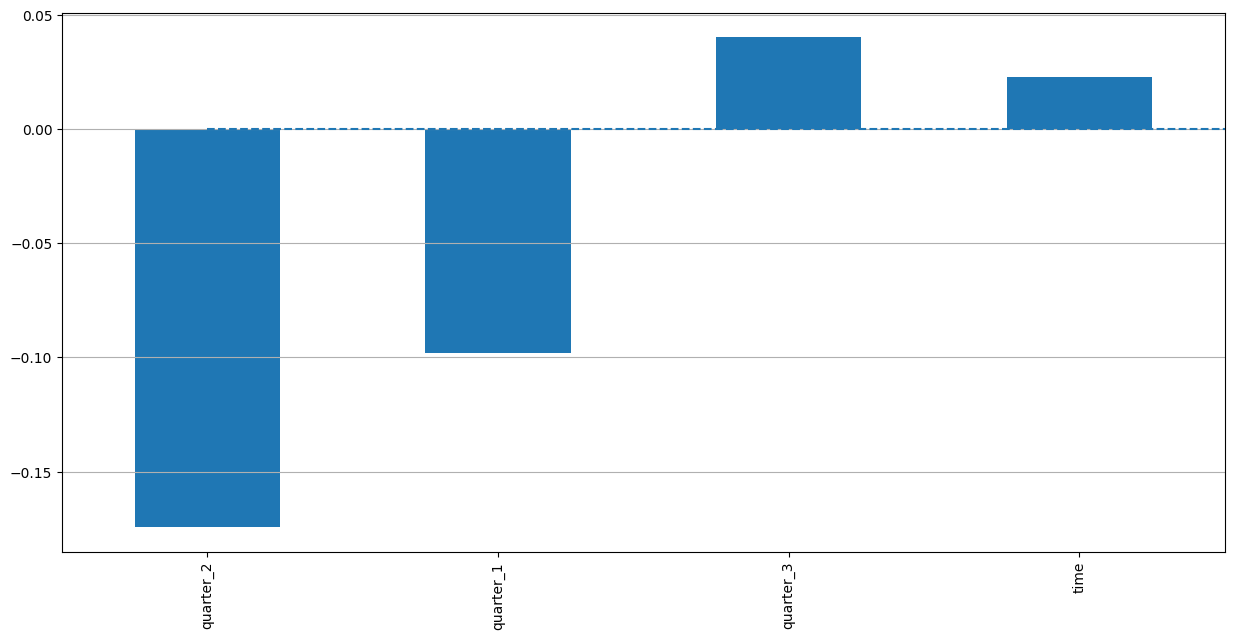

In [ ]:
# Plot Model Results on Test Data
plotModelResults(lr_fitted, X_train, X_test, y_test, plot_intervals=True, test_data=True)

# Plot Feature Importance
plotCoefficients(lr_fitted, X_train)

## Without Scaling

<ipython-input-162-4c3cc38bf2f4>:1: FutureWarning: The argument 'infer_datetime_format' is deprecated and will be removed in a future version. A strict version of it is now the default, see https://pandas.pydata.org/pdeps/0004-consistent-to-datetime-parsing.html. You can safely remove this argument.
  df = pd.read_csv('CocaCola.csv', parse_dates=['Date'], infer_datetime_format=True)


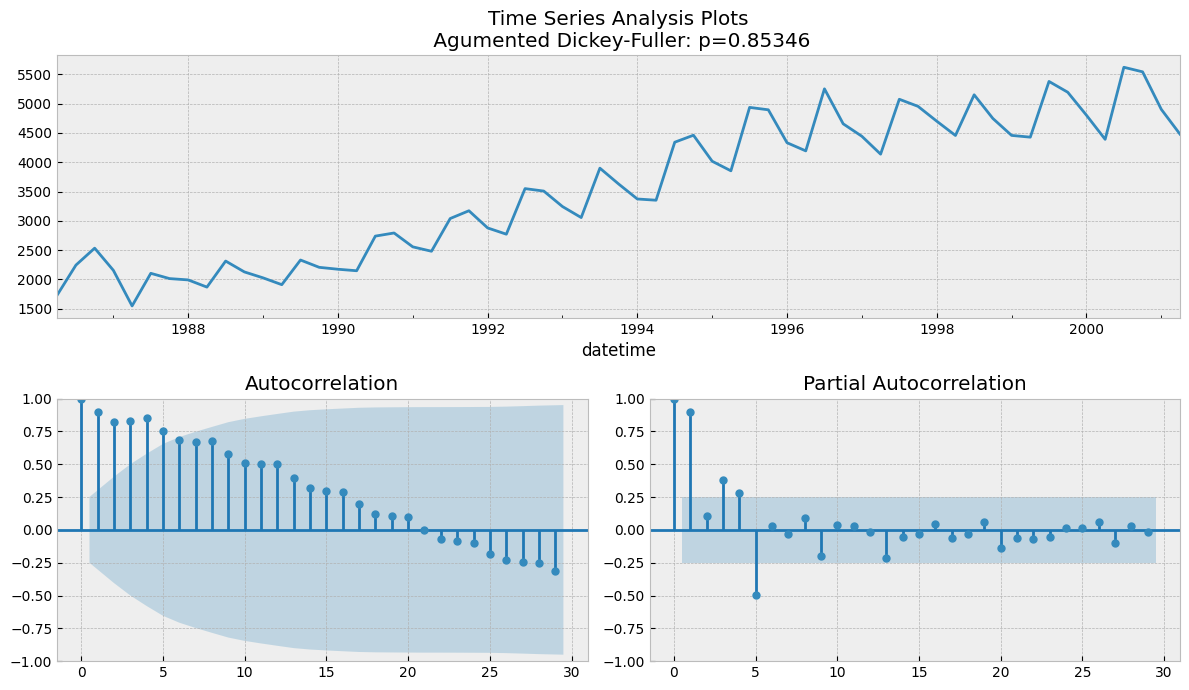

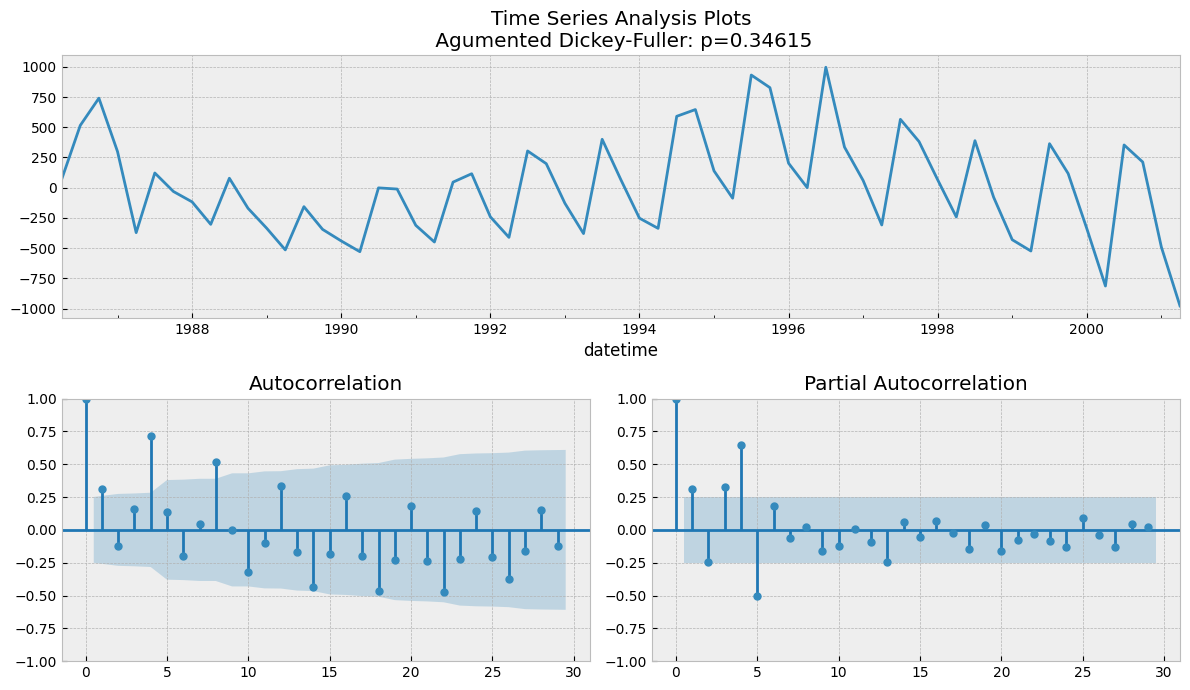

In [ ]:
df = pd.read_csv('CocaCola.csv', parse_dates=['Date'], infer_datetime_format=True)

# Convert the 'Date' column to datetime and create a new 'datetime' column
df["datetime"] = pd.to_datetime(df['Date'])

# Set the 'datetime' column as the index of the DataFrame
df.set_index('datetime', inplace=True)

# Drop the original 'Date' column from the DataFrame
df.drop(["Date"], axis=1, inplace=True)

# Plot original Sales data
tsplot(df["Sales"], lags=29)

# Handle missing values
df.dropna(inplace=True)

# Detrend the data (for diagnostic/visual purposes)
df_detrended = detrendPrice(df)

# Plot the detrended data
tsplot(df_detrended["Sales"], lags=29)


In [ ]:
# SPLIT DATA INTO TRAIN/TEST

# Transform the Sales column by applying a log (for multiplicative seasonality)
df["Sales"] = np.log(df["Sales"])

# Generate 'quarter' column from the datetime index
df["quarter"] = df.index.quarter

# Create dummy variables for quarters
df_dummies = pd.get_dummies(df["quarter"], prefix="quarter").astype(int)

# Join the dummy variables with the original DataFrame
df = df.join(df_dummies)

# Drop the original 'quarter' column and one dummy to avoid dummy trap
df.drop(["quarter", "quarter_4"], axis=1, inplace=True)

# Generate a 'time' feature: sequential numbers from 0 ... length of df-1
df["time"] = range(df.shape[0])

# Define the target variable y and features X
y = df["Sales"]
X = df.drop(["Sales"], axis=1)

# Split data: 80% train, 20% test (no shuffle, to respect time order)
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, shuffle=False, random_state=42
)



3

In [ ]:
# Create a pipeline with StandardScaler and Ridge regression
pipeline = Pipeline([
    ("scaler", StandardScaler()),
    ("ridge", Ridge())
])

# Display the pipeline structure
pipeline

Pipeline(steps=[('scaler', StandardScaler()), ('ridge', Ridge())])

In [ ]:
# Create TimeSeriesSplit with 5 splits for cross-validation
tscv = TimeSeriesSplit(n_splits=5)

In [ ]:
# Define the parameter grid for Ridge regression
param_grid = {
    "ridge__alpha": np.logspace(-5, 5, 150)  # Testing different regularization strengths
}

# Set up GridSearchCV with the pipeline, parameter grid, and cross-validation
grid_search = GridSearchCV(pipeline, param_grid, cv=tscv, scoring="neg_mean_absolute_error")

# Fit the grid search on the TRAINING data
grid_search.fit(X_train, y_train)

print("Best parameters found:", grid_search.best_params_)
print("Best score (negative MAE) found:", grid_search.best_score_)

Best parameters found: {'ridge__alpha': 5.066382636136649}
Best score (negative MAE) found: -0.14865502466292305


In [ ]:
# This is the pipeline (scaler + best ridge).
best_pipeline = grid_search.best_estimator_


best_ridge = grid_search.best_estimator_[1]  # or best_pipeline.named_steps['ridge']

print("Best Ridge model:", best_ridge)
print("Ridge coefficients:", best_ridge.coef_)


Best Ridge model: Ridge(alpha=5.066382636136649)
Ridge coefficients: [-0.03269908 -0.06599646  0.02098942  0.28677516]


In [ ]:
# Predictions on the test set
y_pred_test = best_pipeline.predict(X_test)

# predictions on the train set
y_pred_train = best_pipeline.predict(X_train)


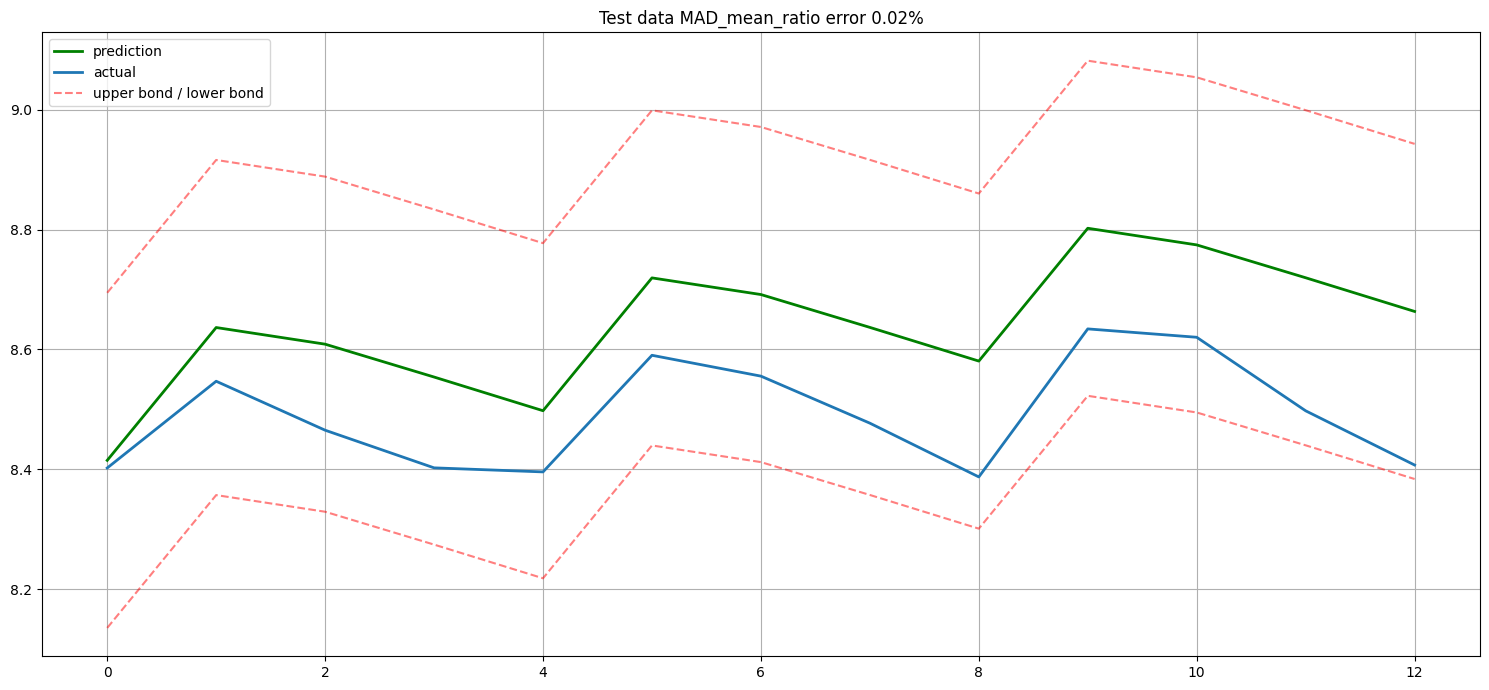

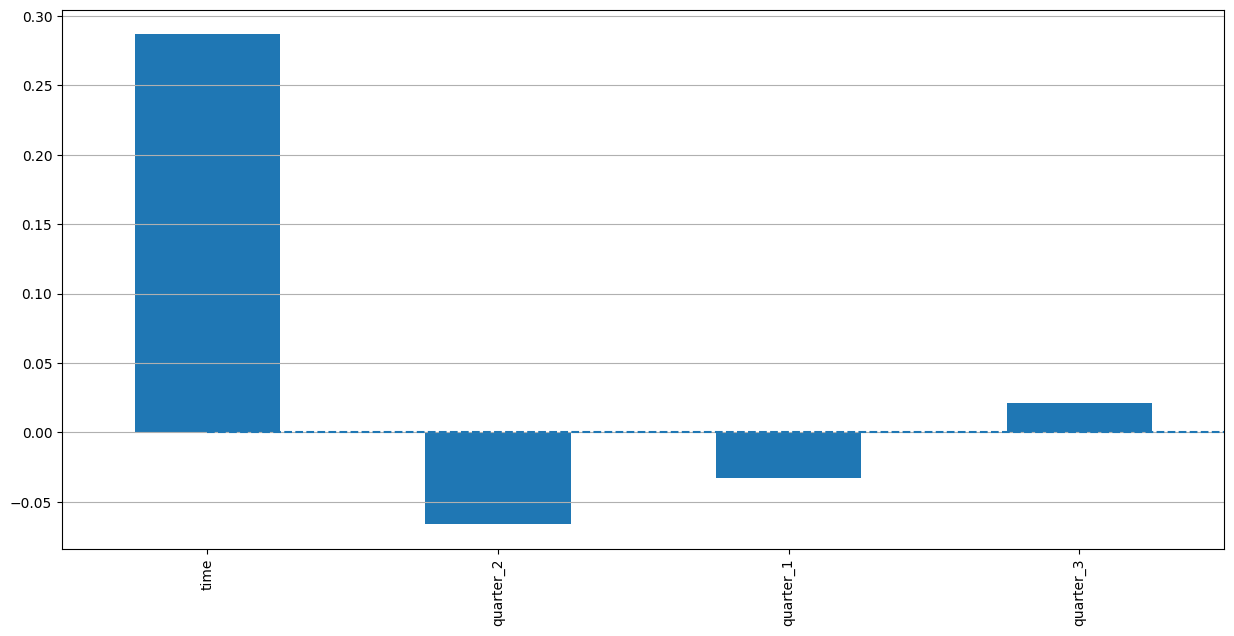

In [ ]:
# Plot Model Results on Test Data
plotModelResults(best_pipeline, X_train, X_test, y_test, plot_intervals=True, test_data=True)

# Plot Feature Importance
plotCoefficients(best_ridge, X_train)

In [ ]:
train_error = MAD_mean_ratio(y_train, y_pred_train)
test_error  = MAD_mean_ratio(y_test,  y_pred_test)

print(f"Train MAD/MEAN ratio: {train_error*100}%")
print(f"Test  MAD/MEAN ratio: {test_error*100}%")


Train MAD/MEAN ratio: 0.8278737707923695%
Test  MAD/MEAN ratio: 1.7374864721368066%


## Last Part

In [ ]:
def LambdaMax(X, Y, model_type):
    from sklearn.linear_model import Ridge
    from sklearn.linear_model import Lasso
    from sklearn.linear_model import LogisticRegression

    if not isinstance(Y, np.ndarray):
         Y = Y.values #for logistic Y values should be categorical
    if not isinstance(X, np.ndarray):
        X = X.values #X values should be scaled

    n = X.shape[0]

    if model_type=="lasso":
        # Calculate LambdaMax for lasso-like regularization
        LambdaMax_lasso = np.max(np.abs(X.T @ Y))

        print("LambdaMax (for Lasso):", LambdaMax_lasso)
        model = Lasso(alpha=LambdaMax_lasso)
        model.fit(X,Y)
        print("lasso coefs", model.coef_ )#coefs should be close to zero

    if model_type == "ridge":
        # Calculate LambdaMax for ridge-like regularization
        LambdaMax_ridge = 2 * np.max(np.abs(X.T @ Y)) / n

        print("LambdaMax (for Ridge):", LambdaMax_ridge)
        model = Ridge(alpha=LambdaMax_ridge)
        model.fit(X,Y)
        print("ridge coefs", model.coef_ )#coefs should be close to zero

    if model_type == "logistic":
        # Fit logistic regression model without regularization (high C value means less regularization)
        model = LogisticRegression(penalty='l2', C=1e10, solver='liblinear')
        model.fit(X, Y)

        # Calculate the gradient of the loss function at the fitted coefficients
        # Logistic loss gradient w.r.t. coefficients: X.T * (Y - p)
        p = model.predict_proba(X)[:, 1]  # model predictions as probabilities
        gradients = np.dot(X.T, (Y - p))  # gradients of the loss function

        # Calculate LambdaMax_logistic for L2 Logistic Regression
        LambdaMax_logistic = np.max(np.abs(gradients))

        print("LambdaMax (for Logistic):", LambdaMax_logistic)
        print("C (for Logistic):", 1/LambdaMax_logistic)
        model =  LogisticRegression(C=1/LambdaMax_logistic) #C = 1/LambdaMax_logistic
        model.fit(X,Y)
        print("logistic coefs",model.coef_ )#coefs should be close to zero

In [ ]:
# Then scale X_train first
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)

# Now compute LambdaMax for Ridge
LambdaMax(X_train_scaled, y_train, "ridge")


LambdaMax (for Ridge): 0.6373766652125602
ridge coefs [-0.04088223 -0.0740413   0.0180983   0.31283849]


In [ ]:
lambda_max_value = 0.6373766652125602  # actual LambdaMax result here

start = lambda_max_value
stop = 0.1
num_points = 50

# Generate a 1D array of 50 evenly-spaced alpha values between [lambda_max, 0.1]
evenly_spaced_values = np.linspace(start, stop, num_points)
param_grid = [{"ridge__alpha": evenly_spaced_values}]


In [ ]:
from sklearn.model_selection import GridSearchCV

grid_search = GridSearchCV(
    estimator=pipeline,
    param_grid=param_grid,
    cv=tscv,
    scoring="neg_mean_absolute_error",
    refit=True
)

grid_search.fit(X_train, y_train)

print("Best Params:", grid_search.best_params_)
print("Best score (neg MAE):", grid_search.best_score_)


Best Params: {'ridge__alpha': 0.6373766652125602}
Best score (neg MAE): -0.16001397348253082


In [ ]:
best_pipeline = grid_search.best_estimator_
y_pred_test = best_pipeline.predict(X_test)

In [ ]:
train_error = MAD_mean_ratio(y_train, y_pred_train)
test_error  = MAD_mean_ratio(y_test,  y_pred_test)

print(f"Train MAD/MEAN ratio: {train_error*100}%")
print(f"Test  MAD/MEAN ratio: {test_error*100}%")

Train MAD/MEAN ratio: 0.8278737707923695%
Test  MAD/MEAN ratio: 2.406456266961958%
